# Vision Project Walkthrough

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
#imageio.plugins.ffmpeg.download()

## Description

in the notebook will walk through the various steps we do to proccess our image and how we extract and apply masks to the image to get the information we need to change the rover mode or steering

### First pick an image 

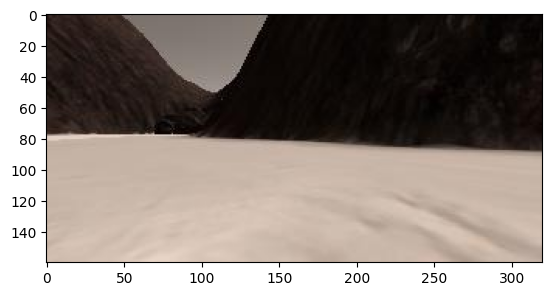

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

### Perception_step

### Define various variables
define the source , destination ,dst size and bottom offset that will be major factor in mapping and various things to warp the image to change it to bird eye view image

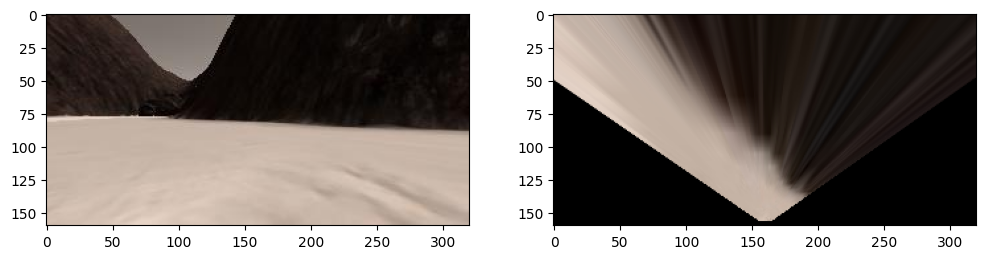

In [4]:
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return warped

def perception_step(image):
    
    #Init some variable that will be used during the perception step
    dst_size= 5
    bottom_offset= 4
    # 1) Define source and destination points for perspective transform
    #numbers are approximated from a test image with grid
    source = np.float32([[14, 140],
                         [300, 140],
                         [200, 95],
                         [120, 95]])
    
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                ])
    
    # 2) Apply perspective transform
    warped = perspect_transform(image, source, destination)
    
    #subplotting
    fig = plt.figure(figsize=(12, 9))
    plt.subplot(221)
    plt.imshow(image)
    plt.subplot(222)
    plt.imshow(warped)
perception_step(image)

### Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

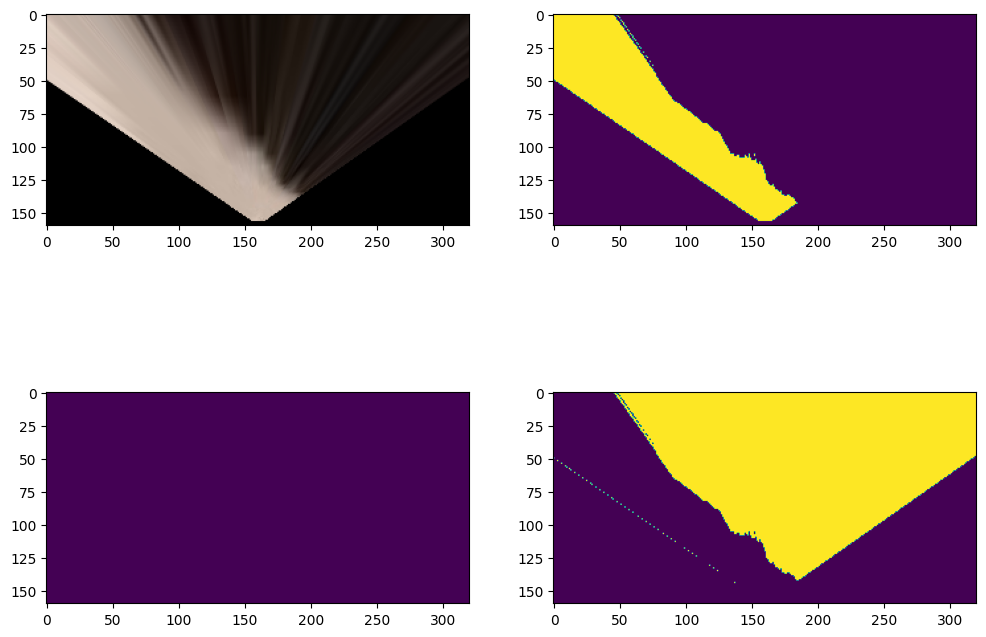

In [5]:
def color_thresh(img, above_thresh,below_thresh=(600,600,600)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh_result = (img[:,:,0] > above_thresh[0]) \
                & (img[:,:,1] > above_thresh[1]) \
                & (img[:,:,2] > above_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh_result] = 1

  
    below_thresh_result = (img[:,:,0] > below_thresh[0]) \
                & (img[:,:,1] > below_thresh[1]) \
                & (img[:,:,2] > below_thresh[2])
    # Index the array of zeros with the boolean array and set to 0
    color_select[below_thresh_result] = 0   

    
    # Return the binary image
    return color_select
def perception_step(image):
    
    #Init some variable that will be used during the perception step
    dst_size= 5
    bottom_offset= 4
    

    
    # 1) Define source and destination points for perspective transform
    #numbers are approximated from a test image with grid
    source = np.float32([[14, 140],
                         [300, 140],
                         [200, 95],
                         [120, 95]])
    
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                ])
    
    # 2) Apply perspective transform
    warped = perspect_transform(image, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #this values derived using the picker tool in photoshop to get the lowest dark color in accepted images
    Terrain_threshold=(150, 150, 150)
    Rock_threshhold=(120,120,-1)
    Rock_threshhold1=(-1,-1,100)
    ###################################################
    #apply the terrain threshold
    terrain_img=color_thresh(warped,Terrain_threshold)
    #apply the rock threshold
    threshed_rock =color_thresh(warped,Rock_threshhold,Rock_threshhold1)
    #################################################
    #obstacle 
    white = cv2.bitwise_not(np.zeros_like(image)) #white image 
    warped_white = perspect_transform(white, source, destination)# warping our mask 
    warped_white_threshed = color_thresh(warped_white,(1,1,1))#thresholding not needed
    not_terrain = cv2.bitwise_not(terrain_img) #invert the terrain image
    obstacle = cv2.bitwise_and(warped_white_threshed,not_terrain)#applying the mask to the inverted image
    blank = np.zeros_like(warped)
    ##########################################
    #subplotting
    fig = plt.figure(figsize=(12, 9))
    plt.subplot(221)
    plt.imshow(warped)
    plt.subplot(222)
    plt.imshow(terrain_img)
    plt.subplot(223)
    plt.imshow(threshed_rock)
    plt.subplot(224)
    plt.imshow(obstacle)
    
perception_step(image)

### Clipping
we noticed the further we looked the worst the data was and unreliable so we decided to clip it and using one form of image to decide all the Rover decisions was impossible so to fix that we also made 3 pictures from terrain img<br />
terrain_img : for mapping<br />
terrain_forward : to check if there is enough space to go forward or to stop<br />
terrain_steering : is responsible for steering<br />
every image has a different clipping mask to ensure the best result and to make special decision from them like hugging the wall or not map beyond the map and many more.<br/>
the terrain_steering has some errosion applied to avoid steering into the small space between rocks too.


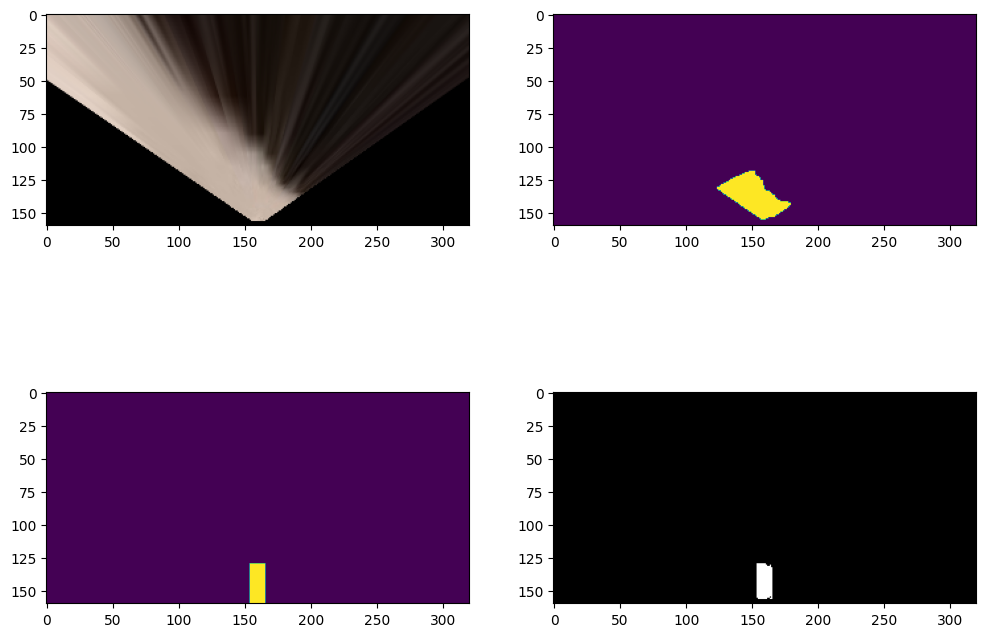

In [10]:
def perception_step(image):
    
    #Init some variable that will be used during the perception step
    dst_size= 5
    bottom_offset= 4
    
    # 1) Define source and destination points for perspective transform
    #numbers are approximated from a test image with grid
    source = np.float32([[14, 140],
                         [300, 140],
                         [200, 95],
                         [120, 95]])
    
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                ])
    
    # 2) Apply perspective transform
    warped = perspect_transform(image, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #this values derived using the picker tool in photoshop to get the lowest dark color in accepted images
    Terrain_threshold=(160, 160, 160)
    Rock_threshhold=(120,120,-1)
    Rock_threshhold1=(-1,-1,60)
    ###################################################
    #apply the terrain threshold
    terrain_img=color_thresh(warped,Terrain_threshold)
    #apply the rock threshold
    threshed_rock =color_thresh(warped,Rock_threshhold,Rock_threshhold1)
    #################################################
    #obstacle 
    white = cv2.bitwise_not(np.zeros_like(image)) #white image 
    warped_white = perspect_transform(white, source, destination)# warping our mask 
    warped_white_threshed = color_thresh(warped_white,(1,1,1))#thresholding not needed
    not_terrain = cv2.bitwise_not(terrain_img) #invert the terrain image
    obstacle = cv2.bitwise_and(warped_white_threshed,not_terrain)#applying the mask to the inverted image
    blank = np.zeros_like(warped)
    #######################################################################
    #masking section
    #######################################################################
    #mask to check if the rover keep going forward or stop
    #######################################################################
   
    ##########################################
    rect =cv2.rectangle(blank.copy(), (154,130),(165,160), (255,255,255), -1)
    rect=color_thresh(rect,(1,1,1))
    terrain_forward = cv2.bitwise_and(terrain_img,rect)#FORWARD NAVIGATION
    

    # ###################################
    #different circle for different mask purposes
    circle = cv2.circle(blank.copy(),((warped.shape[1]//2)-48,(warped.shape[1]//2 +80)),130,(255,255,255),-1)
    circle = color_thresh(circle,(254,254,254))
    #######################################################
    #masking for terrain that will change the steering angle
    #######################################################
    terrain_img2 = cv2.bitwise_and(terrain_img,circle)
    terrain_img2=scipy.ndimage.binary_erosion(terrain_img2, structure=np.ones((6,6))).astype(terrain_img2.dtype)
    
    
    ##################################################
    #masking for terrain and obstacles that will be used to map the world map
    ##################################################
    #changing circle again
    circle = cv2.circle(blank.copy(),((warped.shape[1]//2)+25,(warped.shape[1]//2 +65)),115,(255,255,255),-1)
    circle = color_thresh(circle,(254,254,254))
    #applying the clipping
    obstacle = cv2.bitwise_and(obstacle,circle)
    terrain_img = cv2.bitwise_and(terrain_img,circle)
    #applying errosion to make sure thin paths that arent accessible not changing our steering toward rocks
    terrain_img=scipy.ndimage.binary_erosion(terrain_img, structure=np.ones((4,4))).astype(terrain_img.dtype)
    
    
    #plotting
    fig = plt.figure(figsize=(12, 9))
    plt.subplot(221)
    plt.imshow(warped)
    plt.subplot(222)
    plt.imshow(terrain_img)
    
    plt.subplot(223)
    plt.imshow(rect)
    plt.subplot(224)
    plt.imshow(terrain_forward,cmap='gray')
    # plt.subplot(325)
    # plt.imshow(circle)
    # plt.subplot(326)
    # plt.imshow(terrain_img2)
    # plt.subplot(223)
    # plt.imshow(threshed_rock)
    # plt.subplot(224)
    # plt.imshow(obstacle)
    
perception_step(image)